In [2]:
# Data preparation for Ph.D thesis
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [4]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [5]:
# Paths
# Paths for symbols (not eft)
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output'])
# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=DATA_PATH # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
filename = 'timeseries_created_1576000391' # 'timeseries_created_1574259300' 'timeseries_created_1574272163' 
FIELD = 'ts' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename+'.csv'])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename+'_indicators.csv'])

In [6]:
# Open file
df=pd.read_csv(file)
df['close'] = df[FIELD]
df['open'] = df[FIELD].shift(1) # close value of previous period/row
initial_len = len(df)
df.dropna(inplace=True) # remove first row as open is NaN
assert len(df) + 1 == initial_len
df['high'] = pd.np.maximum(df['open'], df['close'])
df['low'] = pd.np.minimum(df['open'], df['close'])
df = df[['open','close','high','low']]
df.head()

,open,close,high,low
1,227.513851,227.507703,227.513851,227.507703
2,227.507703,227.501554,227.507703,227.501554
3,227.501554,227.495406,227.501554,227.495406
4,227.495406,227.514533,227.514533,227.495406
5,227.514533,227.532159,227.532159,227.514533


In [7]:
#Add parameters to transform in TS
timeseries=['close']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4
1,227.513851,227.507703,227.513851,227.507703,NaN,NaN,NaN,NaN
2,227.507703,227.501554,227.507703,227.501554,227.507703,NaN,NaN,NaN
3,227.501554,227.495406,227.501554,227.495406,227.501554,227.507703,NaN,NaN
4,227.495406,227.514533,227.514533,227.495406,227.495406,227.501554,227.507703,NaN
5,227.514533,227.532159,227.532159,227.514533,227.514533,227.495406,227.501554,227.507703


In [8]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
1,227.513851,227.507703,227.513851,227.507703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,227.510777,227.509752,227.509240,NaN,NaN,NaN,NaN,NaN,NaN
2,227.507703,227.501554,227.507703,227.501554,227.507703,NaN,NaN,NaN,NaN,NaN,...,NaN,227.504629,227.503604,227.503092,NaN,NaN,NaN,NaN,227.513851,NaN
3,227.501554,227.495406,227.501554,227.495406,227.501554,227.507703,NaN,NaN,NaN,NaN,...,NaN,227.498480,227.497456,227.496943,NaN,NaN,NaN,NaN,227.513605,NaN
4,227.495406,227.514533,227.514533,227.495406,227.495406,227.501554,227.507703,NaN,NaN,NaN,...,NaN,227.504969,227.508157,227.509751,NaN,NaN,NaN,NaN,227.495406,NaN
5,227.514533,227.532159,227.532159,227.514533,227.514533,227.495406,227.501554,227.507703,227.510271,NaN,...,NaN,227.523346,227.526283,227.527752,NaN,NaN,NaN,NaN,227.495406,NaN


In [10]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
# df = df[26000:]
df.dropna(inplace=True)
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
34,227.992997,228.007830,228.007830,227.992997,227.992997,227.976413,227.958240,227.941180,227.975332,227.934156,...,228.002886,228.004122,0.016249,0.110769,0.111621,-0.000851,227.926093,0.050645,228.023554,1
35,228.007830,228.023554,228.023554,228.007830,228.007830,227.992997,227.976413,227.958240,227.991807,227.950590,...,228.018313,228.019623,0.016197,0.110542,0.111405,-0.000863,227.942440,0.050591,228.041394,1
36,228.023554,228.041394,228.041394,228.023554,228.023554,228.007830,227.992997,227.976413,228.008438,227.967195,...,228.035447,228.036934,0.016361,0.110457,0.111215,-0.000758,227.958663,0.050579,228.059192,1
37,228.041394,228.059192,228.059192,228.041394,228.041394,228.023554,228.007830,227.992997,228.024993,227.983778,...,228.053260,228.054743,0.016505,0.110483,0.111069,-0.000586,227.975209,0.050628,228.074855,1
38,228.059192,228.074855,228.074855,228.059192,228.059192,228.041394,228.023554,228.007830,228.041365,228.000181,...,228.069634,228.070939,0.016421,0.110435,0.110942,-0.000507,227.992006,0.050660,228.089701,1


In [ ]:
df = df[41200:]


In [11]:
# Select columns for output
# columns_selected=[
#                  'rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']

# selection through grid search
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
# output.to_csv(RESULT_FILEPATH_PROCESSED, sep=';', encoding='utf-8', index = False)

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

Class distribution: 
0 in 0.7192793624629477%
1 in 0.2807206375370523%


<IPython.core.display.Javascript object>

In [ ]:
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=';', encoding='utf-8', index = False)

In [ ]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df[:100000].plot(y=["close_t-1"])
plt.show()

In [23]:
len(df)

5999965

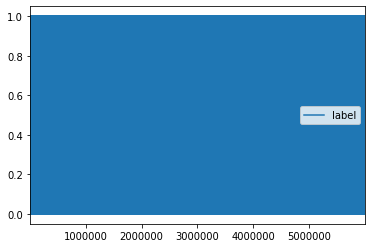

In [24]:
output.plot(y=["label"])
